## SVM Implementations

Simple linear and gaussian kernel implementations for SVM, with no numerical optimization tricks, and using basic gradient descent. Tested on toy datasets.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import latex
from sklearn import datasets
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Linear Kernel

Important components:

$$ Cost = \left\{
\begin{array}{l1}
      max (0,1-\theta^{T}x) \text{ if y=1}\\
      max (0,1+\theta^{T}x) \text{ if y=0}\\
\end{array} 
\right. $$

$$ J(\theta) = c\sum_{i=1}^{m} y^{(i)}*max(0,1-\theta^{T}x^{(i)}) + (1-y^{(i)})*max(0,1+\theta^{T}x^{(i)})
   + \frac{1}{2}\sum_{j=1}^{n}\theta_j^2 $$

In [2]:
# dataset for the linear svm kernel
iris = datasets.load_iris()
X = iris.data[:,0:2]
y = iris.target
# Using only two classes:
X = X[:100]
y = y[:100]

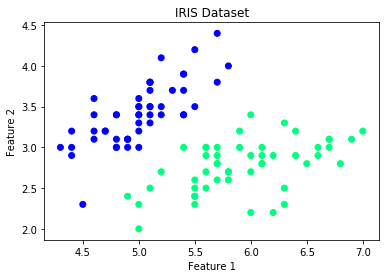

In [3]:
# it is easily discernable that this data is linearly separable
plt.scatter(X[:,0],X[:,1],c=y,cmap="winter")
plt.title("IRIS Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [4]:
# adding a column of ones for the intercept
ones = np.ones((100,1))
X2 = np.hstack((ones,X))
# creating the training and testing datasets
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.2)
X_train,X_test,y_train,y_test = torch.from_numpy(X_train),torch.from_numpy(X_test),torch.from_numpy(y_train),torch.from_numpy(y_test)
y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)

In [5]:
def cost(betas,pred,y,c=1):
    """ Returns the cost outlined earlier for the linear SVM kernel. l2 norm is canceled out for simplicity.
    """
    pred_1 = pred.clone() # predictions for y=1 cost component
    pred_0 = pred.clone() # predictions for y=0 cost component
    pred_1[pred_1>=1] = 0 ; pred_1[pred_1<1] = pred_1[pred_1<1] * -1 + 1
    pred_0[pred_0<=-1] = 0 ; pred_0[pred_0>-1] += 1
    
    main_cost = c * torch.sum((y*pred_1) + ((1-y)*pred_0))
    l2_norm = 0 # 1/2 * torch.sum(betas[1:,:]**2) # no penalty for intercept term
    total_cost = main_cost + l2_norm
    return total_cost

In [15]:
betas = torch.randn(3,1)
betas = betas.double()
betas.requires_grad = True
betas.shape

torch.Size([3, 1])

In [16]:
lr = 0.0001

for i in range(400): # training loop
    pred = torch.mm(X_train,betas)
    acost = cost(betas,pred,y_train)
    print("epoch {} cost: {}".format(i+1,float(acost)))
    acost.backward()
    betas.data.sub_(lr * betas.grad.data)
    betas.grad.zero_()

epoch 1 cost: 179.0005170971155
epoch 2 cost: 172.34339609711554
epoch 3 cost: 165.6862750971155
epoch 4 cost: 159.0291540971155
epoch 5 cost: 152.3720330971155
epoch 6 cost: 145.7149120971155
epoch 7 cost: 139.0577910971155
epoch 8 cost: 131.44986404387998
epoch 9 cost: 116.45685365696716
epoch 10 cost: 98.37950752300787
epoch 11 cost: 89.54095075061178
epoch 12 cost: 85.28284462654638
epoch 13 cost: 85.10541662654637
epoch 14 cost: 84.92798862654638
epoch 15 cost: 84.75056062654637
epoch 16 cost: 83.57765671281051
epoch 17 cost: 83.40843671281051
epoch 18 cost: 83.23921671281052
epoch 19 cost: 83.06999671281052
epoch 20 cost: 82.9007767128105
epoch 21 cost: 82.73155671281052
epoch 22 cost: 82.56233671281052
epoch 23 cost: 82.39311671281051
epoch 24 cost: 82.22389671281051
epoch 25 cost: 82.05467671281052
epoch 26 cost: 81.88545671281051
epoch 27 cost: 81.71623671281051
epoch 28 cost: 81.5470167128105
epoch 29 cost: 81.37779671281052
epoch 30 cost: 81.20857671281051
epoch 31 cost: 81.

epoch 373 cost: 38.194660597582725
epoch 374 cost: 39.09478093257659
epoch 375 cost: 38.999630932576586
epoch 376 cost: 38.90448093257659
epoch 377 cost: 38.80933093257659
epoch 378 cost: 38.71418093257658
epoch 379 cost: 38.61903093257658
epoch 380 cost: 38.52388093257658
epoch 381 cost: 38.42873093257657
epoch 382 cost: 38.33358093257658
epoch 383 cost: 38.23843093257658
epoch 384 cost: 39.14374782437892
epoch 385 cost: 38.05026593257657
epoch 386 cost: 37.955115932576575
epoch 387 cost: 38.861348824378915
epoch 388 cost: 37.76695093257658
epoch 389 cost: 38.67196482437891
epoch 390 cost: 37.57878593257657
epoch 391 cost: 37.483635932576576
epoch 392 cost: 38.389565824378906
epoch 393 cost: 37.29547093257656
epoch 394 cost: 37.20032093257655
epoch 395 cost: 38.1071668243789
epoch 396 cost: 37.012155932576555
epoch 397 cost: 37.9177828243789
epoch 398 cost: 36.82399093257656
epoch 399 cost: 36.72884093257655
epoch 400 cost: 37.6353838243789


In [25]:
# determining the training set error
predictions = pred.clone()
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print("Training set accuracy: {}".format(float(sum(predictions==y_train))/len(y_train)))

Training set accuracy: 0.9875


In [26]:
# determining the test set error
with torch.no_grad():
    pred = torch.mm(X_test,betas)
predictions = pred.clone()
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print("Test set accuracy: {}".format(float(sum(predictions==y_test))/len(y_test)))

Test set accuracy: 1.0


### Gaussian Kernel

Important components:

$$ x^{(i)}: f_1^{(i)} = sim(x^{(i)},\ell^{(1)}) = exp\big( \frac{||x^{(i)} - \ell^{(1)}||^2}{2\sigma^2} \big) $$

$$ f^{(i)} = [f_1^{(i)}, f_2^{(i)}, ..., f_m^{(i)}]  $$

$$ Cost = \left\{
\begin{array}{l1}
      max (0,1-\theta^{T}f) \text{ if y=1}\\
      max (0,1+\theta^{T}f) \text{ if y=0}\\
\end{array} 
\right. $$

$$ J(\theta) = c\sum_{i=1}^{m} y^{(i)}*max(0,1-\theta^{T}f^{(i)}) + (1-y^{(i)})*max(0,1+\theta^{T}f^{(i)})
   + \frac{1}{2}\sum_{j=1}^{n}\theta_j^2 $$

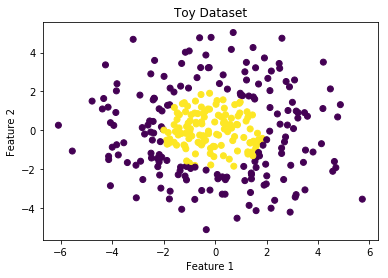

In [13]:
# creating toy data in which the classes are not linearly separable
r = 2 # radius of circle centered at (0,0) which represents y=1
a = np.random.randn(300,2)*2
y = np.zeros(300,)
y_d = np.sqrt(np.sum(a**2,axis=1))
y[y_d < r] = 1

plt.scatter(a[:,0],a[:,1],c=y)
plt.title("Toy Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [14]:
# adding a column of ones for the intercept - note: this is not necessary as it will be canceled out in kernel step
ones = np.ones((300,1))
X = np.hstack([ones,a])
# creating the training and testing datasets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train,X_test,y_train,y_test = torch.from_numpy(X_train),torch.from_numpy(X_test),torch.from_numpy(y_train),torch.from_numpy(y_test)
y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([240, 3]),
 torch.Size([60, 3]),
 torch.Size([240, 1]),
 torch.Size([60, 1]))

In [15]:
def gaussian_kernel(to_project,project_onto,sigma=1):
    """ Projects to_project onto project_onto using gaussian kernel (project_onto will be training set)
    """
    f = []
    for r in range(len(to_project)): # looping through the rows
        x = to_project[r]
        #print(1,x.shape) #(3)
        numerator = torch.sqrt(torch.sum((project_onto-x)**2,dim=1))
        #print(2,numerator.shape) #(240)
        f_r = torch.exp(numerator/(2*sigma**2))
        #print(3,f_r.shape) #(240)
        f_r = torch.cat([torch.ones(1).double(),f_r]) # adding one as placeholder for intercept
        #print(4,f_r.shape) #(241)
        f.append(f_r)
    f = torch.stack(f)
    return f

In [16]:
f_train = gaussian_kernel(X_train,X_train)
f_test = gaussian_kernel(X_test,X_train)
f_train.shape,f_test.shape

(torch.Size([240, 241]), torch.Size([60, 241]))

In [17]:
betas = torch.randn(241,1)
betas = betas.double()
betas.requires_grad = True
betas.shape

torch.Size([241, 1])

In [19]:
lr = 0.0001

for i in range(500): # training loop
    pred = torch.mm(f_train,betas)
    acost = cost(betas,pred,y_train)
    print("epoch {} cost: {}".format(i+1,float(acost)))
    acost.backward()
    betas.data.sub_(lr * betas.grad.data)
    betas.grad.zero_()

epoch 1 cost: 576.909909100918
epoch 2 cost: 602.2439049829414
epoch 3 cost: 552.722254513487
epoch 4 cost: 625.3114793575603
epoch 5 cost: 528.5345999260566
epoch 6 cost: 646.6854831788698
epoch 7 cost: 588.8654672225332
epoch 8 cost: 649.2850281804742
epoch 9 cost: 546.5249654532495
epoch 10 cost: 628.251874229621
epoch 11 cost: 566.3545732779945
epoch 12 cost: 608.9939787970251
epoch 13 cost: 543.3947713327457
epoch 14 cost: 579.6217404804687
epoch 15 cost: 571.5429505510305
epoch 16 cost: 602.6893148550868
epoch 17 cost: 547.3552959635996
epoch 18 cost: 625.7568892297054
epoch 19 cost: 525.1708484690142
epoch 20 cost: 596.3846509131495
epoch 21 cost: 552.5436732366351
epoch 22 cost: 619.4522252877678
epoch 23 cost: 530.0107064359918
epoch 24 cost: 590.079986971212
epoch 25 cost: 557.73205050967
epoch 26 cost: 613.1475613458305
epoch 27 cost: 534.8505644029696
epoch 28 cost: 583.7753230292742
epoch 29 cost: 562.1812763920714
epoch 30 cost: 665.1179509585282
epoch 31 cost: 694.232824

epoch 255 cost: 244.99281292785727
epoch 256 cost: 244.02420508110202
epoch 257 cost: 242.82596075515568
epoch 258 cost: 245.1978494758808
epoch 259 cost: 242.711940066794
epoch 260 cost: 245.22259328391735
epoch 261 cost: 243.7336083342237
epoch 262 cost: 242.5079883399148
epoch 263 cost: 245.427629831941
epoch 264 cost: 242.3939676515533
epoch 265 cost: 245.4523736399774
epoch 266 cost: 243.44301158734544
epoch 267 cost: 243.25664834925328
epoch 268 cost: 243.53337328881491
epoch 269 cost: 243.07700976745858
epoch 270 cost: 242.6809486059504
epoch 271 cost: 244.9629002950942
epoch 272 cost: 243.3823587909912
epoch 273 cost: 245.93502056105842
epoch 274 cost: 243.71643401049835
epoch 275 cost: 244.52097078318795
epoch 276 cost: 242.84988288342538
epoch 277 cost: 246.19089400133942
epoch 278 cost: 244.59655148348176
epoch 279 cost: 242.44499595793306
epoch 280 cost: 247.5261169939273
epoch 281 cost: 242.37282130145766
epoch 282 cost: 247.43481832369093
epoch 283 cost: 242.3006466449822

In [20]:
# determining the training set error
predictions = pred.clone()
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print("Training set accuracy: {}".format(float(sum(predictions==y_train))/len(y_train)))

Training set accuracy: 0.9875


In [21]:
# determining the test set error
with torch.no_grad():
    pred = torch.mm(f_test,betas)
predictions = pred.clone()
predictions[predictions>=0] = 1
predictions[predictions<0] = 0
print("Test set accuracy: {}".format(float(sum(predictions==y_test))/len(y_test)))

Test set accuracy: 0.9666666666666667
